# Data Cleaning

In [4]:
import pandas as pd
import numpy as np

# Load dataset and filter to Power 5 games
df = pd.read_csv("cfb_box-scores_2002-2024.csv")

p5 = {"sec", "acc", "big10", "big12", "pac12"}
df = df[df["conf_home"].isin(p5) & df["conf_away"].isin(p5)].copy()

# Add game-level outcome for reference (not target)
df["point_diff"] = df["score_home"] - df["score_away"]

# Define base features for per-game averaging
features_to_average = [
    'pass_yards_home', 'pass_yards_away',
    'rush_yards_home', 'rush_yards_away',
    'total_yards_home', 'total_yards_away',
    'pass_att_home', 'pass_att_away',
    'third_down_comp_home', 'third_down_comp_away',
    'third_down_att_home', 'third_down_att_away',
    'pen_num_home', 'pen_num_away',
    'pen_yards_home', 'pen_yards_away',
    'fum_home', 'fum_away',
    'int_home', 'int_away',
    'first_downs_home', 'first_downs_away',
    'possession_home', 'possession_away'
]

# Sort chronologically
df = df.sort_values(["season", "week"])

# Convert to long format for rolling averages
home_stats = df[["season", "week", "home"] + [f for f in features_to_average if f.endswith("_home")]].copy()
away_stats = df[["season", "week", "away"] + [f for f in features_to_average if f.endswith("_away")]].copy()

home_stats.columns = ["season", "week", "team"] + [f.replace("_home", "") for f in home_stats.columns[3:]]
away_stats.columns = ["season", "week", "team"] + [f.replace("_away", "") for f in away_stats.columns[3:]]

team_stats = pd.concat([home_stats, away_stats], ignore_index=True)
team_stats = team_stats.sort_values(["team", "season", "week"])

# --- Custom feature engineering per team per game ---
team_stats["penalty_rate"] = team_stats["pen_yards"] / team_stats["pen_num"].replace(0, np.nan)
team_stats["turnovers"] = team_stats["fum"] + team_stats["int"]
team_stats["pass_eff"] = team_stats["pass_yards"] / team_stats["pass_att"].replace(0, np.nan)
team_stats["third_down_pct"] = team_stats["third_down_comp"] / team_stats["third_down_att"].replace(0, np.nan)

# --- Compute rolling averages (exclude current game) ---
all_rolling_feats = [
    'pass_yards', 'rush_yards', 'total_yards', 'pass_att',
    'third_down_comp', 'third_down_att', 'pen_num', 'pen_yards',
    'fum', 'int', 'first_downs', 'possession',
    'penalty_rate', 'turnovers', 'pass_eff', 'third_down_pct'
]

for feat in all_rolling_feats:
    team_stats[f"{feat}_avg"] = team_stats.groupby(["team", "season"])[feat].shift(1).expanding().mean()

# --- Merge rolling features back into main df for home and away teams ---
# For home
home_avg = team_stats[["season", "week", "team"] + [f"{feat}_avg" for feat in all_rolling_feats]].copy()
home_avg.columns = ["season", "week", "home"] + [f"{feat}_avg_home" for feat in all_rolling_feats]
df = df.merge(home_avg, on=["season", "week", "home"], how="left")

# For away
away_avg = team_stats[["season", "week", "team"] + [f"{feat}_avg" for feat in all_rolling_feats]].copy()
away_avg.columns = ["season", "week", "away"] + [f"{feat}_avg_away" for feat in all_rolling_feats]
df = df.merge(away_avg, on=["season", "week", "away"], how="left")

# Fill NaNs (early season games)
avg_cols = [col for col in df.columns if "_avg_" in col]
df[avg_cols] = df[avg_cols].fillna(0)

#For teams that are unranked, we will rank them 26

# --- Final feature and target setup ---
model_features = (
    [f"{feat}_avg_home" for feat in all_rolling_feats] +
    [f"{feat}_avg_away" for feat in all_rolling_feats] +
    ['rank_home', 'rank_away', 'neutral']
)

X = df[model_features].copy()
y = df[["score_home", "score_away"]].copy()


In [5]:
# Fix rank columns: fill missing with 26 (unranked)
X["rank_home"] = X["rank_home"].fillna(26)
X["rank_away"] = X["rank_away"].fillna(26)

# Ensure neutral is integer type
X["neutral"] = X["neutral"].astype(int)

In [6]:
X

,pass_yards_avg_home,rush_yards_avg_home,total_yards_avg_home,pass_att_avg_home,third_down_comp_avg_home,third_down_att_avg_home,pen_num_avg_home,pen_yards_avg_home,fum_avg_home,int_avg_home,...,int_avg_away,first_downs_avg_away,possession_avg_away,penalty_rate_avg_away,turnovers_avg_away,pass_eff_avg_away,third_down_pct_avg_away,rank_home,rank_away,neutral
0,227.774801,156.728703,379.234854,31.375487,5.536521,14.313347,5.379069,46.128796,0.718112,0.910917,...,0.904317,20.255369,26.059720,8.628327,1.613509,7.457099,0.387419,13.0,26.0,0
1,227.384694,156.839426,378.973864,31.292962,5.521011,14.281517,5.387598,46.168944,0.713700,0.903997,...,0.782152,21.685039,26.109974,8.552194,1.467192,8.093595,0.421920,10.0,26.0,0
2,229.408866,160.187227,384.243220,31.282881,5.528142,14.247594,5.458443,46.726451,0.735491,0.893847,...,0.896127,20.560739,25.831144,8.537351,1.636444,7.497680,0.386261,26.0,3.0,0
3,227.836879,158.091573,380.618481,31.172716,5.490613,14.233417,5.442011,46.477263,0.727159,0.896120,...,0.909896,20.302460,26.066662,8.643987,1.618245,7.447962,0.387069,13.0,11.0,0
4,229.408866,160.187227,384.243220,31.282881,5.528142,14.247594,5.458443,46.726451,0.735491,0.893847,...,0.895494,20.129665,25.813096,8.585388,1.625104,7.484326,0.384965,26.0,26.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6949,231.722892,159.923439,386.800000,31.592881,5.575465,14.289485,5.473165,47.079189,0.708981,0.905257,...,0.902841,19.977788,25.975322,8.625031,1.618918,7.429962,0.385463,5.0,8.0,1
6950,231.722892,159.923439,386.800000,31.592881,5.575465,14.289485,5.473165,47.079189,0.708981,0.905257,...,0.902704,19.977791,25.975791,8.624761,1.618674,7.430693,0.385459,5.0,8.0,1
6951,231.728507,159.912277,386.794984,31.593692,5.575402,14.289563,5.473114,47.079947,0.709013,0.905268,...,0.902826,19.977180,25.974286,8.625079,1.619012,7.429540,0.385454,5.0,8.0,1
6952,231.728507,159.912277,386.794984,31.593692,5.575402,14.289563,5.473114,47.079947,0.709013,0.905268,...,0.902841,19.977788,25.975322,8.625031,1.618918,7.429962,0.385463,5.0,8.0,1


# Basic Linear Regression: First Attempt

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2
)

# Fit a baseline linear regression model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predict both home and away scores
y_pred = baseline_model.predict(X_test)

# Evaluate the model
mse_home = mean_squared_error(y_test["score_home"], y_pred[:, 0])
mse_away = mean_squared_error(y_test["score_away"], y_pred[:, 1])
mae_home = mean_absolute_error(y_test["score_home"], y_pred[:, 0])
mae_away = mean_absolute_error(y_test["score_away"], y_pred[:, 1])

print("=== Baseline Linear Regression ===")
print(f"Home Score MSE: {mse_home:.2f}, MAE: {mae_home:.2f}")
print(f"Away Score MSE: {mse_away:.2f}, MAE: {mae_away:.2f}")


=== Baseline Linear Regression ===
Home Score MSE: 173.98, MAE: 10.61
Away Score MSE: 157.68, MAE: 10.14


## Visualizations

Home R²: 0.09024059772491455


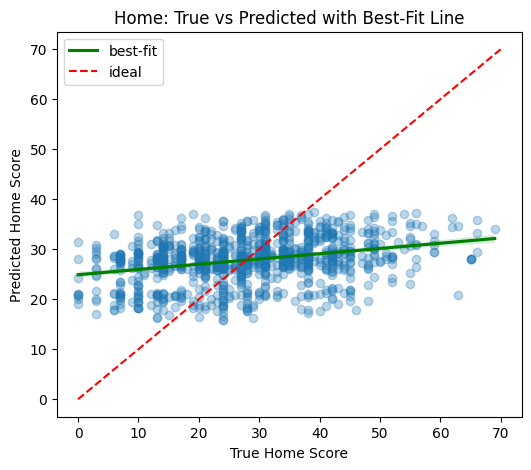

Away R²: 0.10973721742630005


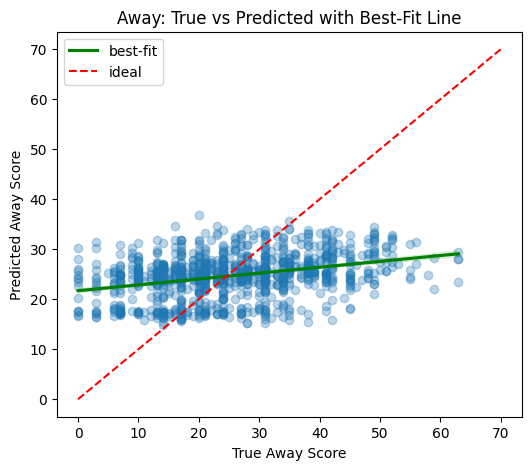

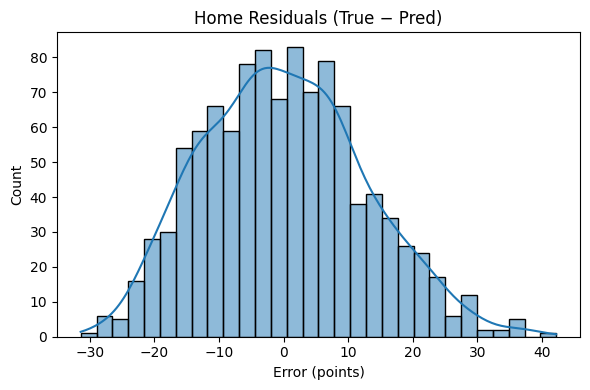

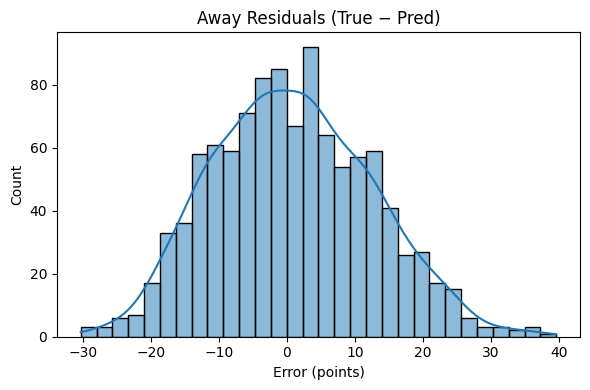

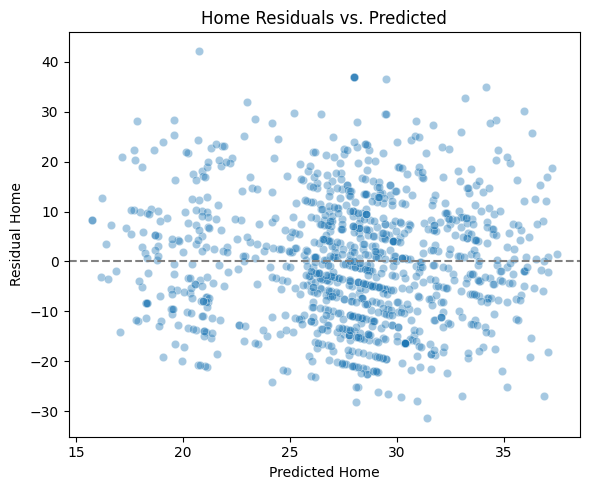

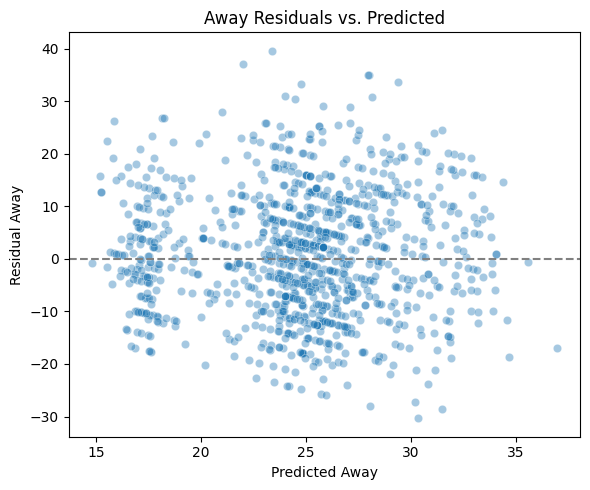

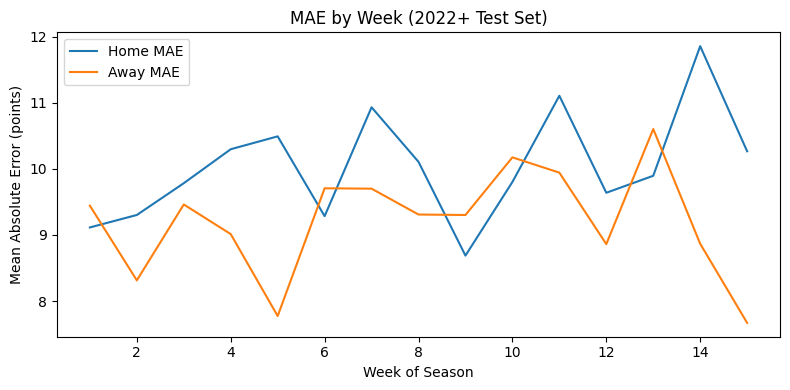

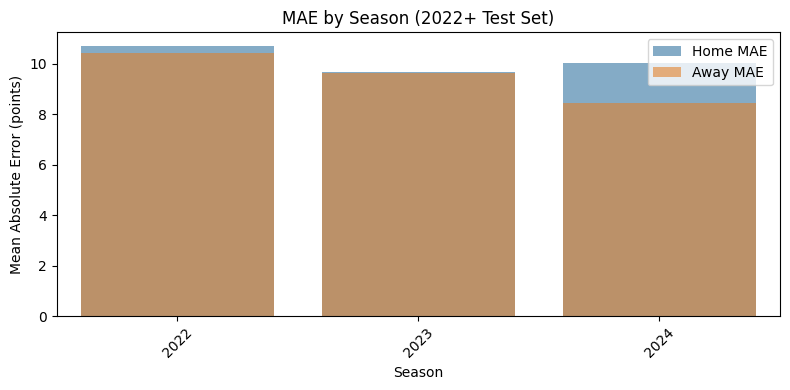

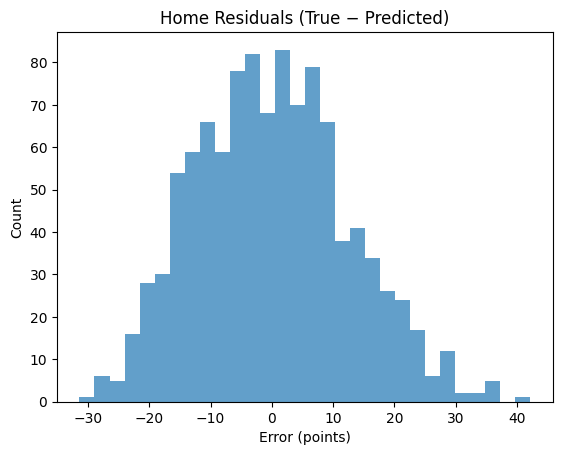

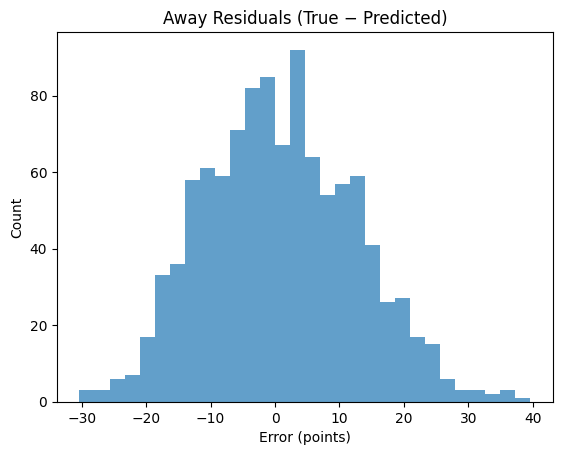

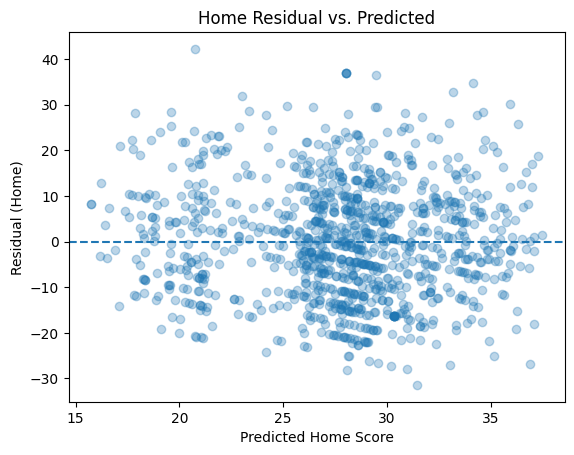

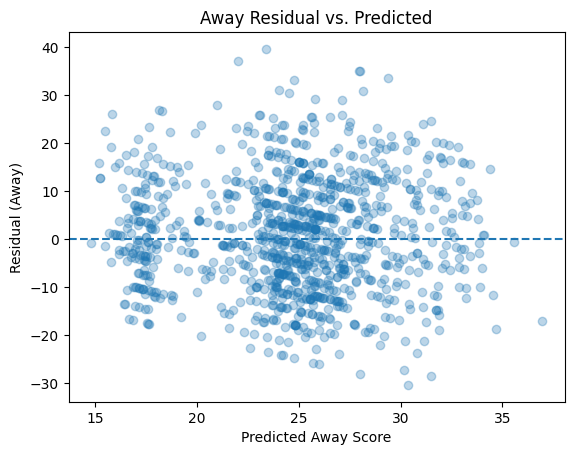

In [27]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Home score
true_h = y_test["score_home"].values
pred_h = y_pred[:,0]

print("Home R²:", r2_score(true_h, pred_h))

plt.figure(figsize=(6,5))
sns.regplot(x=true_h, y=pred_h,
            scatter_kws={"alpha":0.3},
            line_kws={"color":"green", "label":"best‐fit"})
plt.plot([0,70],[0,70],"r--", label="ideal")
plt.xlabel("True Home Score")
plt.ylabel("Predicted Home Score")
plt.title("Home: True vs Predicted with Best‐Fit Line")
plt.legend()
plt.show()

# Away score
true_a = y_test["score_away"].values
pred_a = y_pred[:,1]

print("Away R²:", r2_score(true_a, pred_a))

plt.figure(figsize=(6,5))
sns.regplot(x=true_a, y=pred_a,
            scatter_kws={"alpha":0.3},
            line_kws={"color":"green", "label":"best‐fit"})
plt.plot([0,70],[0,70],"r--", label="ideal")
plt.xlabel("True Away Score")
plt.ylabel("Predicted Away Score")
plt.title("Away: True vs Predicted with Best‐Fit Line")
plt.legend()
plt.show()


# 3) Residual histograms
plt.figure(figsize=(6,4))
sns.histplot(df_vis['resid_home'], bins=30, kde=True)
plt.title("Home Residuals (True − Pred)") 
plt.xlabel("Error (points)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df_vis['resid_away'], bins=30, kde=True)
plt.title("Away Residuals (True − Pred)")
plt.xlabel("Error (points)")
plt.tight_layout()
plt.show()

# 4) Residuals vs. Predicted (check for heteroscedasticity)
plt.figure(figsize=(6,5))
sns.scatterplot(x='pred_home', y='resid_home', data=df_vis, alpha=0.4)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Home")
plt.ylabel("Residual Home")
plt.title("Home Residuals vs. Predicted")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x='pred_away', y='resid_away', data=df_vis, alpha=0.4)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Away")
plt.ylabel("Residual Away")
plt.title("Away Residuals vs. Predicted")
plt.tight_layout()
plt.show()

# 5) Mean Absolute Error by Week
week_mae = df_vis.assign(abs_err_home=df_vis['resid_home'].abs(),
                          abs_err_away=df_vis['resid_away'].abs()) \
                .groupby('week')[['abs_err_home','abs_err_away']].mean() \
                .reset_index()

plt.figure(figsize=(8,4))
sns.lineplot(x='week', y='abs_err_home', data=week_mae, label='Home MAE')
sns.lineplot(x='week', y='abs_err_away', data=week_mae, label='Away MAE')
plt.xlabel("Week of Season")
plt.ylabel("Mean Absolute Error (points)")
plt.title("MAE by Week (2022+ Test Set)")
plt.tight_layout()
plt.show()

# 6) Season‐by‐Season MAE (to see drift over years)
season_mae = df_vis.assign(abs_err_home=df_vis['resid_home'].abs(),
                           abs_err_away=df_vis['resid_away'].abs()) \
                 .groupby('season')[['abs_err_home','abs_err_away']].mean() \
                 .reset_index()

plt.figure(figsize=(8,4))
sns.barplot(x='season', y='abs_err_home', data=season_mae, color='C0', alpha=0.6, label='Home MAE')
sns.barplot(x='season', y='abs_err_away', data=season_mae, color='C1', alpha=0.6, label='Away MAE')
plt.xticks(rotation=45)
plt.xlabel("Season")
plt.ylabel("Mean Absolute Error (points)")
plt.title("MAE by Season (2022+ Test Set)")
plt.legend()
plt.tight_layout()
plt.show()
import seaborn as sns
from sklearn.metrics import r2_score




# --- 2) Residual Histograms (Home & Away) ---
resid_home = y_test["score_home"] - y_pred[:,0]
resid_away = y_test["score_away"] - y_pred[:,1]

plt.figure()
plt.hist(resid_home, bins=30, alpha=0.7)
plt.title("Home Residuals (True − Predicted)")
plt.xlabel("Error (points)")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(resid_away, bins=30, alpha=0.7)
plt.title("Away Residuals (True − Predicted)")
plt.xlabel("Error (points)")
plt.ylabel("Count")
plt.show()


# --- 3) Residuals vs. Predicted (to spot heteroscedasticity) ---
plt.figure()
plt.scatter(y_pred[:,0], resid_home, alpha=0.3)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Home Score")
plt.ylabel("Residual (Home)")
plt.title("Home Residual vs. Predicted")
plt.show()

plt.figure()
plt.scatter(y_pred[:,1], resid_away, alpha=0.3)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Away Score")
plt.ylabel("Residual (Away)")
plt.title("Away Residual vs. Predicted")
plt.show()


# Basic Linear Regression: Improved Features

In the initial version of the model, while the data processing was thorough and well-structured, there were several key limitations that likely impacted predictive accuracy. First, the use of expanding averages for team stats gave equal weight to all past games, failing to account for more recent performance, which is often more indicative of a team's current strength. Additionally, early-season games with no prior data were imputed with zeros, introducing unrealistic noise into the model. The train/test split was done randomly rather than chronologically, leading to potential data leakage from future games into the training set. Furthermore, the model lacked opponent-adjusted features, contextual variables like season or week, and did not address multicollinearity among highly correlated stats. In the improved version, we replaced expanding means with 4-game rolling averages to emphasize recent performance, used chronological train/test splitting to preserve time-series integrity, added deltas between home and away rolling stats to better capture relative matchups, and included season and week as control variables. We also applied mean imputation to handle any remaining missing values robustly and scaled features properly before fitting the model, resulting in a cleaner, more context-aware baseline.

In [47]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# ===========================
# 1. Load and Filter Dataset
# ===========================
df = pd.read_csv("cfb_box-scores_2002-2024.csv")

p5 = {"sec", "acc", "big10", "big12", "pac12"}
df = df[df["conf_home"].isin(p5) & df["conf_away"].isin(p5)].copy()
df["point_diff"] = df["score_home"] - df["score_away"]
df = df.sort_values(["season", "week"]).reset_index(drop=True)

# ===========================
# 2. Rolling Feature Engineering
# ===========================
features_to_average = [
    'pass_yards_home', 'pass_yards_away',
    'rush_yards_home', 'rush_yards_away',
    'total_yards_home', 'total_yards_away',
    'pass_att_home', 'pass_att_away',
    'third_down_comp_home', 'third_down_comp_away',
    'third_down_att_home', 'third_down_att_away',
    'pen_num_home', 'pen_num_away',
    'pen_yards_home', 'pen_yards_away',
    'fum_home', 'fum_away',
    'int_home', 'int_away',
    'first_downs_home', 'first_downs_away',
    'possession_home', 'possession_away'
]

home_stats = df[["season", "week", "home"] + [f for f in features_to_average if f.endswith("_home")]].copy()
away_stats = df[["season", "week", "away"] + [f for f in features_to_average if f.endswith("_away")]].copy()
home_stats.columns = ["season", "week", "team"] + [f.replace("_home", "") for f in home_stats.columns[3:]]
away_stats.columns = ["season", "week", "team"] + [f.replace("_away", "") for f in away_stats.columns[3:]]

team_stats = pd.concat([home_stats, away_stats], ignore_index=True)
team_stats = team_stats.sort_values(["team", "season", "week"])

# Derived stats
team_stats["penalty_rate"] = team_stats["pen_yards"] / team_stats["pen_num"].replace(0, np.nan)
team_stats["turnovers"] = team_stats["fum"] + team_stats["int"]
team_stats["pass_eff"] = team_stats["pass_yards"] / team_stats["pass_att"].replace(0, np.nan)
team_stats["third_down_pct"] = team_stats["third_down_comp"] / team_stats["third_down_att"].replace(0, np.nan)

# All rolling features (with a 4-game window)
all_rolling_feats = [
    'pass_yards', 'rush_yards', 'total_yards', 'pass_att',
    'third_down_comp', 'third_down_att', 'pen_num', 'pen_yards',
    'fum', 'int', 'first_downs', 'possession',
    'penalty_rate', 'turnovers', 'pass_eff', 'third_down_pct'
]

for feat in all_rolling_feats:
    team_stats[f"{feat}_avg"] = (
        team_stats
        .groupby(["team", "season"])[feat]
        .shift(1)
        .rolling(window=4, min_periods=1)
        .mean()
    )

# Merge back rolling averages
home_avg = team_stats[["season", "week", "team"] + [f"{feat}_avg" for feat in all_rolling_feats]].copy()
home_avg.columns = ["season", "week", "home"] + [f"{feat}_avg_home" for feat in all_rolling_feats]
df = df.merge(home_avg, on=["season", "week", "home"], how="left")

away_avg = team_stats[["season", "week", "team"] + [f"{feat}_avg" for feat in all_rolling_feats]].copy()
away_avg.columns = ["season", "week", "away"] + [f"{feat}_avg_away" for feat in all_rolling_feats]
df = df.merge(away_avg, on=["season", "week", "away"], how="left")

# Intelligent imputation
avg_cols = [col for col in df.columns if "_avg_" in col]
feature_means = df[avg_cols].mean()
df[avg_cols] = df[avg_cols].fillna(feature_means)

# ===========================
# 3. Feature Engineering: Deltas and Control Vars
# ===========================
# Compute home-away deltas
for feat in all_rolling_feats:
    df[f"{feat}_delta"] = df[f"{feat}_avg_home"] - df[f"{feat}_avg_away"]

# Final feature set
model_features = [f"{feat}_delta" for feat in all_rolling_feats] + [
    'rank_home', 'rank_away', 'neutral', 'season', 'week'
]

# Target variables
X = df[model_features].copy()
y = df[["score_home", "score_away"]].copy()

# Fix ranks and neutral
X["rank_home"] = X["rank_home"].fillna(26)
X["rank_away"] = X["rank_away"].fillna(26)
X["neutral"] = X["neutral"].astype(int)

# ===========================
# 4. Chronological Train/Test Split
# ===========================
train_df = df[df["season"] < 2022].copy()
test_df = df[df["season"] >= 2022].copy()

X_train = X.loc[train_df.index]
X_test = X.loc[test_df.index]
y_train = y.loc[train_df.index]
y_test = y.loc[test_df.index]

# Fill any remaining NaNs with column means (safety net)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())  # use train mean for consistency


# ===========================
# 5. Scale and Fit Linear Model
# ===========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# ===========================
# 6. Evaluate Results
# ===========================
mse_home = mean_squared_error(y_test["score_home"], y_pred[:, 0])
mae_home = mean_absolute_error(y_test["score_home"], y_pred[:, 0])
mse_away = mean_squared_error(y_test["score_away"], y_pred[:, 1])
mae_away = mean_absolute_error(y_test["score_away"], y_pred[:, 1])

print("=== Improved Linear Regression Model ===")
print(f"Home Score - MSE: {mse_home:.2f}, MAE: {mae_home:.2f}")
print(f"Away Score - MSE: {mse_away:.2f}, MAE: {mae_away:.2f}")


=== Improved Linear Regression Model ===
Home Score - MSE: 152.29, MAE: 10.05
Away Score - MSE: 138.24, MAE: 9.60


## Visualizations

Home R²: 0.09024059772491455


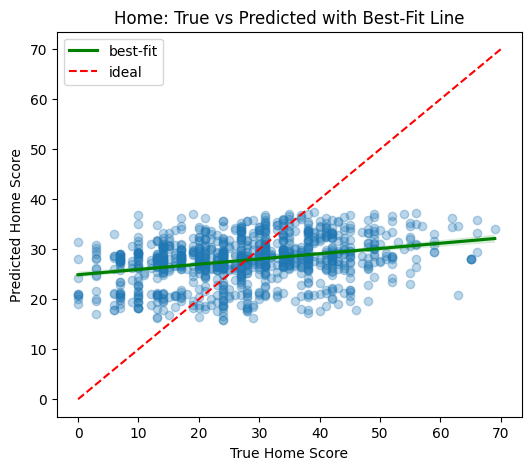

Away R²: 0.10973721742630005


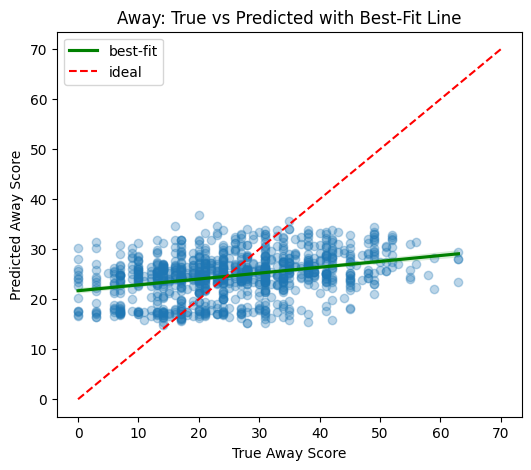

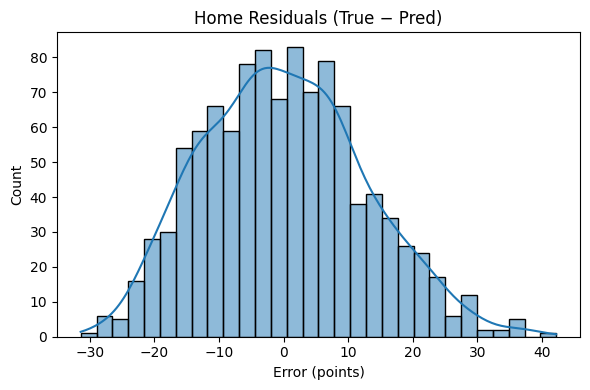

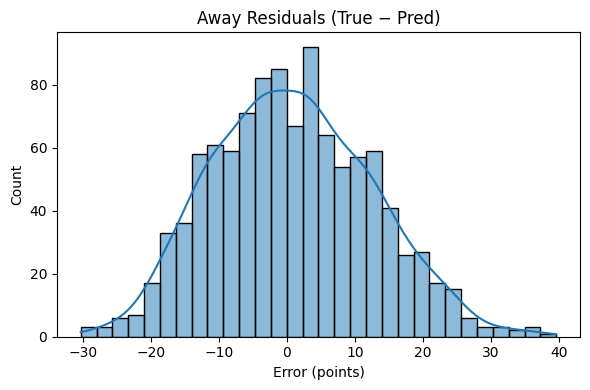

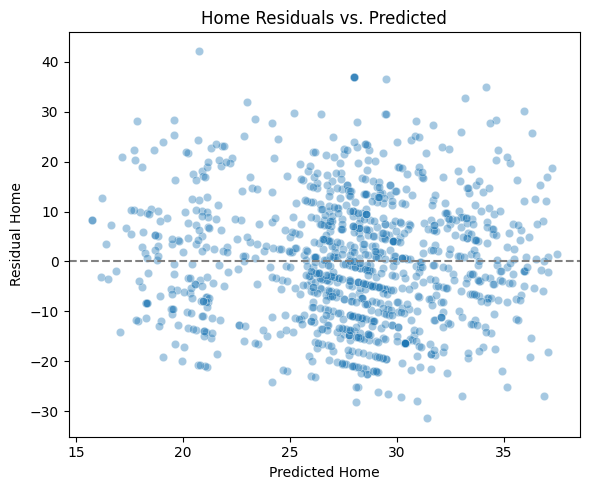

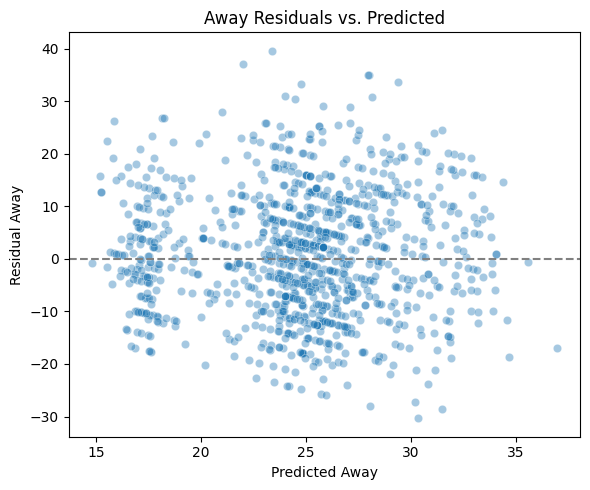

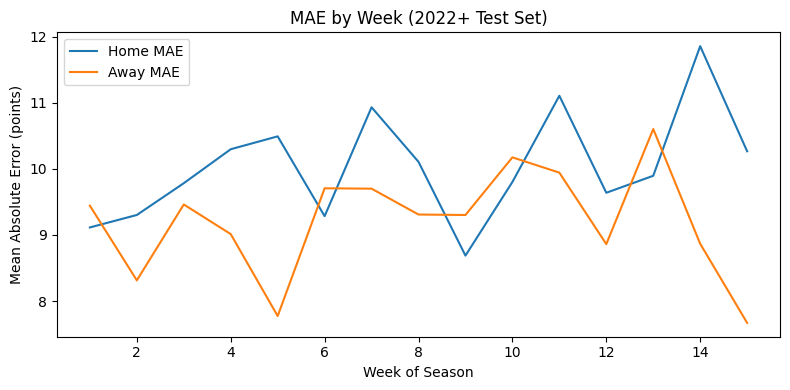

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Home score
true_h = y_test["score_home"].values
pred_h = y_pred[:,0]

print("Home R²:", r2_score(true_h, pred_h))

plt.figure(figsize=(6,5))
sns.regplot(x=true_h, y=pred_h,
            scatter_kws={"alpha":0.3},
            line_kws={"color":"green", "label":"best‐fit"})
plt.plot([0,70],[0,70],"r--", label="ideal")
plt.xlabel("True Home Score")
plt.ylabel("Predicted Home Score")
plt.title("Home: True vs Predicted with Best‐Fit Line")
plt.legend()
plt.show()

# Away score
true_a = y_test["score_away"].values
pred_a = y_pred[:,1]

print("Away R²:", r2_score(true_a, pred_a))

plt.figure(figsize=(6,5))
sns.regplot(x=true_a, y=pred_a,
            scatter_kws={"alpha":0.3},
            line_kws={"color":"green", "label":"best‐fit"})
plt.plot([0,70],[0,70],"r--", label="ideal")
plt.xlabel("True Away Score")
plt.ylabel("Predicted Away Score")
plt.title("Away: True vs Predicted with Best‐Fit Line")
plt.legend()
plt.show()



# 3) Residual histograms
plt.figure(figsize=(6,4))
sns.histplot(df_vis['resid_home'], bins=30, kde=True)
plt.title("Home Residuals (True − Pred)") 
plt.xlabel("Error (points)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df_vis['resid_away'], bins=30, kde=True)
plt.title("Away Residuals (True − Pred)")
plt.xlabel("Error (points)")
plt.tight_layout()
plt.show()

# 4) Residuals vs. Predicted (check for heteroscedasticity)
plt.figure(figsize=(6,5))
sns.scatterplot(x='pred_home', y='resid_home', data=df_vis, alpha=0.4)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Home")
plt.ylabel("Residual Home")
plt.title("Home Residuals vs. Predicted")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x='pred_away', y='resid_away', data=df_vis, alpha=0.4)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Away")
plt.ylabel("Residual Away")
plt.title("Away Residuals vs. Predicted")
plt.tight_layout()
plt.show()

# 5) Mean Absolute Error by Week
week_mae = df_vis.assign(abs_err_home=df_vis['resid_home'].abs(),
                          abs_err_away=df_vis['resid_away'].abs()) \
                .groupby('week')[['abs_err_home','abs_err_away']].mean() \
                .reset_index()

plt.figure(figsize=(8,4))
sns.lineplot(x='week', y='abs_err_home', data=week_mae, label='Home MAE')
sns.lineplot(x='week', y='abs_err_away', data=week_mae, label='Away MAE')
plt.xlabel("Week of Season")
plt.ylabel("Mean Absolute Error (points)")
plt.title("MAE by Week (2022+ Test Set)")
plt.tight_layout()
plt.show()



Home R²: 0.09024059772491455


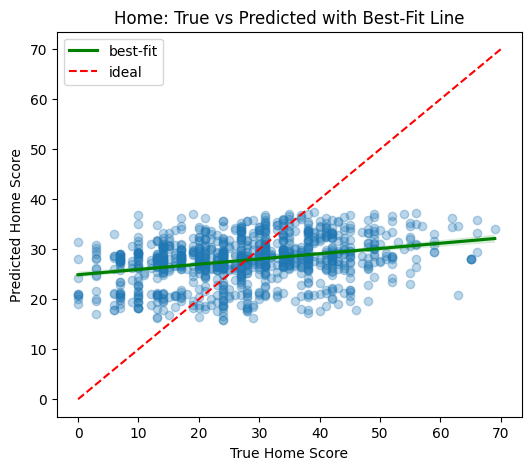

Away R²: 0.10973721742630005


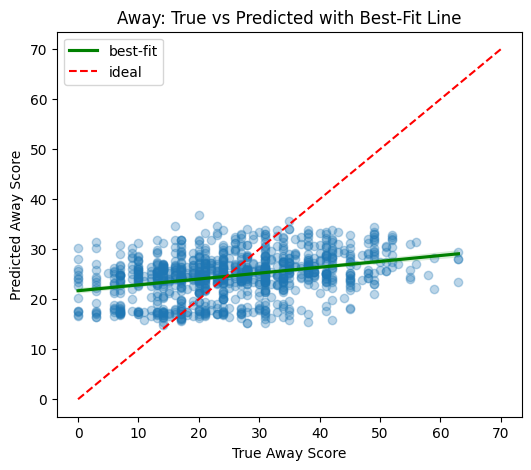

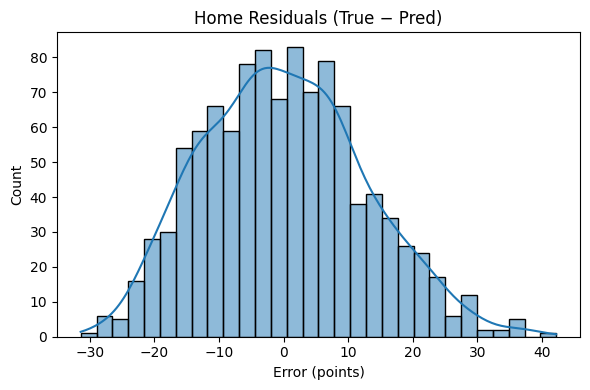

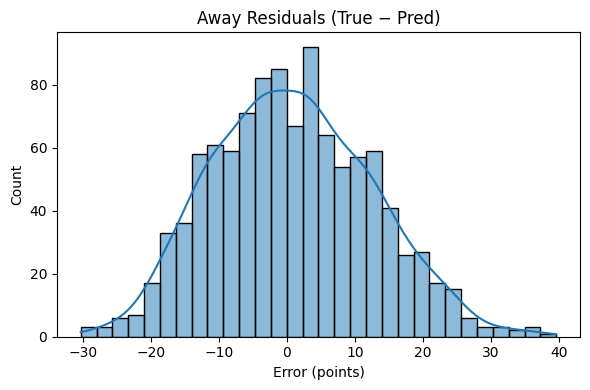

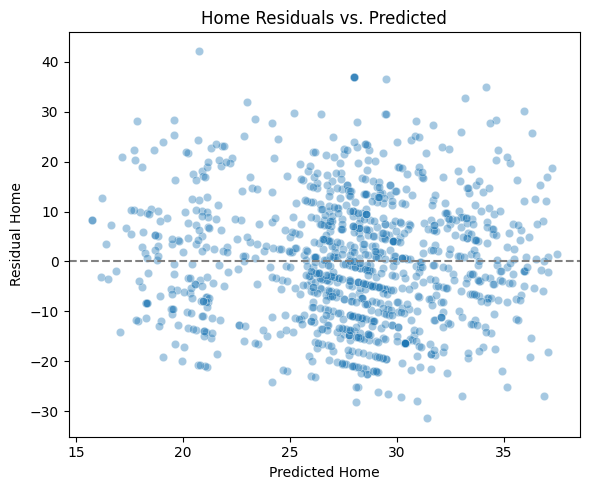

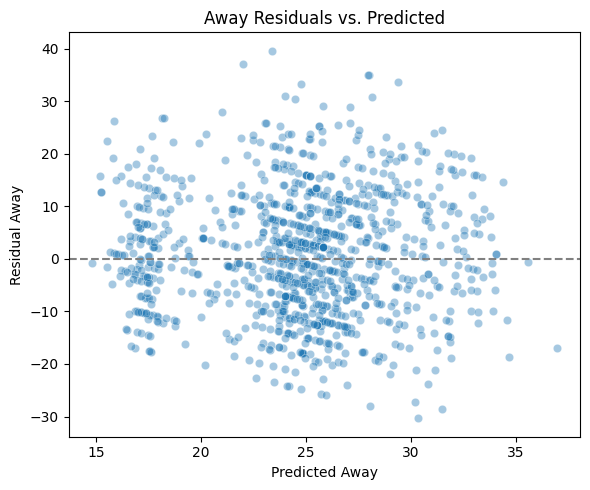

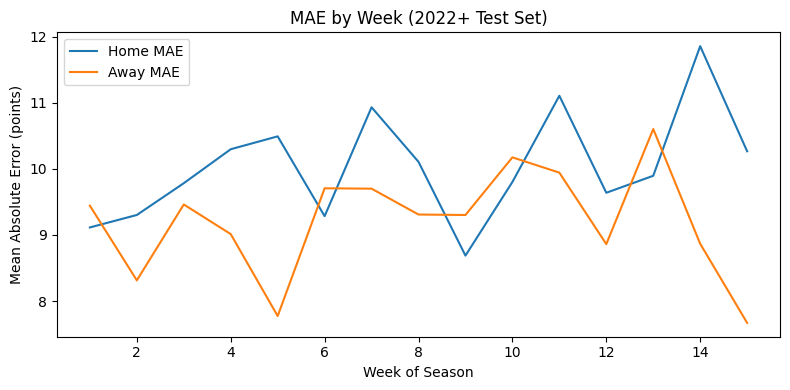

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Home score
true_h = y_test["score_home"].values
pred_h = y_pred[:,0]

print("Home R²:", r2_score(true_h, pred_h))

plt.figure(figsize=(6,5))
sns.regplot(x=true_h, y=pred_h,
            scatter_kws={"alpha":0.3},
            line_kws={"color":"green", "label":"best‐fit"})
plt.plot([0,70],[0,70],"r--", label="ideal")
plt.xlabel("True Home Score")
plt.ylabel("Predicted Home Score")
plt.title("Home: True vs Predicted with Best‐Fit Line")
plt.legend()
plt.show()

# Away score
true_a = y_test["score_away"].values
pred_a = y_pred[:,1]

print("Away R²:", r2_score(true_a, pred_a))

plt.figure(figsize=(6,5))
sns.regplot(x=true_a, y=pred_a,
            scatter_kws={"alpha":0.3},
            line_kws={"color":"green", "label":"best‐fit"})
plt.plot([0,70],[0,70],"r--", label="ideal")
plt.xlabel("True Away Score")
plt.ylabel("Predicted Away Score")
plt.title("Away: True vs Predicted with Best‐Fit Line")
plt.legend()
plt.show()



# 3) Residual histograms
plt.figure(figsize=(6,4))
sns.histplot(df_vis['resid_home'], bins=30, kde=True)
plt.title("Home Residuals (True − Pred)") 
plt.xlabel("Error (points)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df_vis['resid_away'], bins=30, kde=True)
plt.title("Away Residuals (True − Pred)")
plt.xlabel("Error (points)")
plt.tight_layout()
plt.show()

# 4) Residuals vs. Predicted (check for heteroscedasticity)
plt.figure(figsize=(6,5))
sns.scatterplot(x='pred_home', y='resid_home', data=df_vis, alpha=0.4)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Home")
plt.ylabel("Residual Home")
plt.title("Home Residuals vs. Predicted")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x='pred_away', y='resid_away', data=df_vis, alpha=0.4)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted Away")
plt.ylabel("Residual Away")
plt.title("Away Residuals vs. Predicted")
plt.tight_layout()
plt.show()

# 5) Mean Absolute Error by Week
week_mae = df_vis.assign(abs_err_home=df_vis['resid_home'].abs(),
                          abs_err_away=df_vis['resid_away'].abs()) \
                .groupby('week')[['abs_err_home','abs_err_away']].mean() \
                .reset_index()

plt.figure(figsize=(8,4))
sns.lineplot(x='week', y='abs_err_home', data=week_mae, label='Home MAE')
sns.lineplot(x='week', y='abs_err_away', data=week_mae, label='Away MAE')
plt.xlabel("Week of Season")
plt.ylabel("Mean Absolute Error (points)")
plt.title("MAE by Week (2022+ Test Set)")
plt.tight_layout()
plt.show()



# Neural Networks

In [53]:
%load_ext autoreload
%autoreload 2
from cfb import FootballNet, MultiObjectiveLoss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset

# ======= SETUP =======

# Assume df and model_features are already defined
df = df.sort_values(["season", "week"]).reset_index(drop=True)
X = df[model_features].copy()
y = df[["score_home", "score_away"]].copy()

# Fix features
X["rank_home"] = X["rank_home"].fillna(26)
X["rank_away"] = X["rank_away"].fillna(26)
X["neutral"] = X["neutral"].astype(int)

# Chronological split: Train = before 2021, Val = 2021, Test = 2022+
train_df = df[df["season"] < 2021]
val_df = df[df["season"] == 2021]
test_df = df[df["season"] >= 2022]

X_train = X.loc[train_df.index].fillna(X.mean())
y_train = y.loc[train_df.index]

X_val = X.loc[val_df.index].fillna(X.mean())
y_val = y.loc[val_df.index]

X_test = X.loc[test_df.index].fillna(X.mean())
y_test = y.loc[test_df.index]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

# ======= TRAINING =======

input_size = X_train_tensor.shape[1]
model = FootballNet(input_size=input_size, hidden_size=128, dropout=0.2)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

epochs = 100
patience = 10
best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    train_loss = total_loss / len(train_loader)

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor)
        val_loss = loss_fn(val_preds, y_val_tensor).item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.2f} | Val Loss: {val_loss:.2f}")

# Load best model
model.load_state_dict(best_model_state)

# ======= TEST EVALUATION =======

model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor).numpy()
    test_targets = y_test_tensor.numpy()

mse_home = mean_squared_error(test_targets[:, 0], test_preds[:, 0])
mae_home = mean_absolute_error(test_targets[:, 0], test_preds[:, 0])
mse_away = mean_squared_error(test_targets[:, 1], test_preds[:, 1])
mae_away = mean_absolute_error(test_targets[:, 1], test_preds[:, 1])

print("\n=== Final Model Performance on Test Set ===")
print(f"Home Score MSE: {mse_home:.2f}, MAE: {mae_home:.2f}")
print(f"Away Score MSE: {mse_away:.2f}, MAE: {mae_away:.2f}")


Epoch 01 | Train Loss: 910.49 | Val Loss: 874.09
Epoch 02 | Train Loss: 883.10 | Val Loss: 836.78
Epoch 03 | Train Loss: 831.80 | Val Loss: 760.02
Epoch 04 | Train Loss: 735.54 | Val Loss: 642.40
Epoch 05 | Train Loss: 597.87 | Val Loss: 507.54
Epoch 06 | Train Loss: 459.35 | Val Loss: 381.85
Epoch 07 | Train Loss: 358.95 | Val Loss: 304.25
Epoch 08 | Train Loss: 307.38 | Val Loss: 268.65
Epoch 09 | Train Loss: 278.80 | Val Loss: 248.98
Epoch 10 | Train Loss: 263.18 | Val Loss: 233.87
Epoch 11 | Train Loss: 248.55 | Val Loss: 223.17
Epoch 12 | Train Loss: 237.71 | Val Loss: 209.34
Epoch 13 | Train Loss: 225.32 | Val Loss: 196.66
Epoch 14 | Train Loss: 213.40 | Val Loss: 185.44
Epoch 15 | Train Loss: 201.03 | Val Loss: 176.25
Epoch 16 | Train Loss: 195.01 | Val Loss: 169.46
Epoch 17 | Train Loss: 187.61 | Val Loss: 166.86
Epoch 18 | Train Loss: 185.08 | Val Loss: 163.84
Epoch 19 | Train Loss: 183.42 | Val Loss: 162.36
Epoch 20 | Train Loss: 181.55 | Val Loss: 161.45
Epoch 21 | Train Los

=== Random Forest ===
Home Score - MSE: 156.91, MAE: 10.15
Away Score - MSE: 137.49, MAE: 9.54


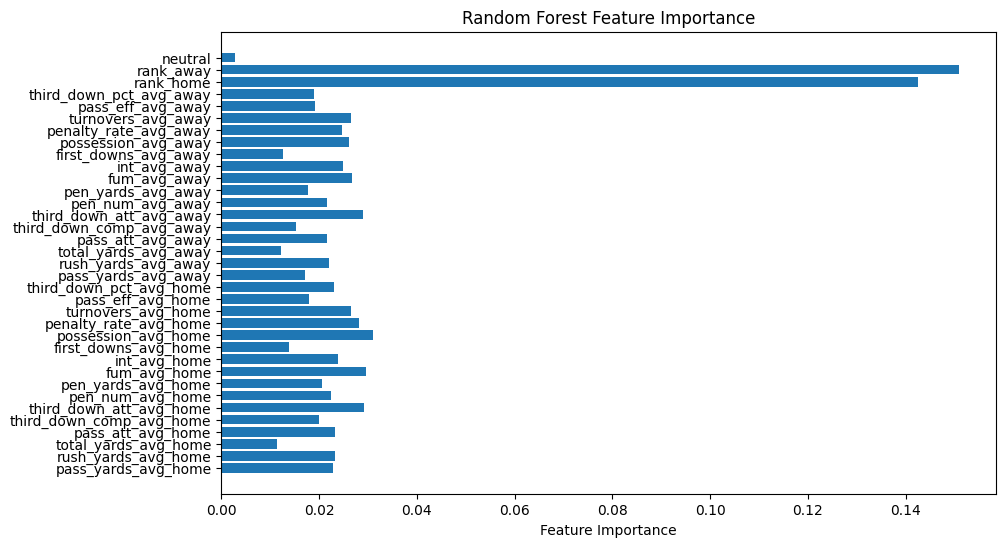

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test_scaled)

# Evaluate
mse_home_rf = mean_squared_error(y_test['score_home'], y_pred_rf[:, 0])
mae_home_rf = mean_absolute_error(y_test['score_home'], y_pred_rf[:, 0])
mse_away_rf = mean_squared_error(y_test['score_away'], y_pred_rf[:, 1])
mae_away_rf = mean_absolute_error(y_test['score_away'], y_pred_rf[:, 1])

print("=== Random Forest ===")
print(f"Home Score - MSE: {mse_home_rf:.2f}, MAE: {mae_home_rf:.2f}")
print(f"Away Score - MSE: {mse_away_rf:.2f}, MAE: {mae_away_rf:.2f}")

# Feature importance
feature_names = model_features
importances = rf.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

# Jackson Work 5-6

In [156]:
# Re-import/re-split X_val and y_val if needed
from sklearn.model_selection import train_test_split

# If necessary, redo the split on X_train_raw and y_train_raw
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y.values, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)



In [157]:
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

In [158]:
import torch.nn as nn

input_size = X_train.shape[1]
hidden_size = 64       # You can experiment with this value
dropout = 0.2          # Standard dropout rate

model = FootballNet(input_size=input_size, hidden_size=hidden_size, dropout=dropout)
loss_fn = nn.MSELoss()  # Standard regression loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


In [159]:
dropouts = [0.1, 0.2, 0.3]
lrs = [0.001, 0.0005]
weight_decays = [0.0, 1e-5]
hidden_sizes = [64, 128]

results = []

In [160]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt


# Hyperparameter grid
dropouts = [0.1, 0.2, 0.3]
lrs = [0.001, 0.0005]
weight_decays = [0.0, 1e-5]
hidden_sizes = [64, 128]

results = []
input_dim = X_train.shape[1]

# Loop through hyperparameters
for dropout in dropouts:
    for lr in lrs:
        for wd in weight_decays:
            for hidden_size in hidden_sizes:
                model = FootballNet(input_size=input_dim, hidden_size=hidden_size, dropout=dropout)
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                loss_fn = nn.MSELoss()

                # Training
                for epoch in range(20):
                    model.train()
                    for xb, yb in train_loader:
                        optimizer.zero_grad()
                        preds = model(xb)
                        loss = loss_fn(preds, yb)
                        loss.backward()
                        optimizer.step()

                # Evaluation
                model.eval()
                with torch.no_grad():
                    val_preds = model(X_val)
                    val_loss = mean_squared_error(y_val.numpy(), val_preds.numpy())

                results.append({
                    "Dropout": dropout,
                    "Learning Rate": lr,
                    "Weight Decay": wd,
                    "Hidden Size": hidden_size,
                    "Val Loss": val_loss
                })

# Show best configurations
df_grid = pd.DataFrame(results).sort_values(by="Val Loss").reset_index(drop=True)
print(df_grid.head(10))


KeyboardInterrupt: 

In [135]:
model = FootballNet(input_size=X_train.shape[1], hidden_size=128, dropout=0.2)
loss_fn = MultiObjectiveLoss(alpha=0.6)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Custom Loss Function model maybe try to have this one be improvement for both home and away? Not exatly sure how to do that

# END of 5-6

# OLD WORK (CAN DELETE)

Let's add some features that could potentially be important. 

In [136]:
import numpy as np
# Ensure p5_scores is a copy so we avoid SettingWithCopyWarning
p5_scores = p5_scores.copy()

# Compute penalty rate safely (yards per penalty), avoid divide-by-zero by replacing 0s with NaN
p5_scores["penalty_rate_home"] = p5_scores["pen_yards_home"] / p5_scores["pen_num_home"].replace(0, np.nan)
p5_scores["penalty_rate_away"] = p5_scores["pen_yards_away"] / p5_scores["pen_num_away"].replace(0, np.nan)

# Fill NaNs with 0 for now (TODO: consider better imputation strategy like mean or median)
p5_scores["penalty_rate_home"] = p5_scores["penalty_rate_home"].fillna(0)
p5_scores["penalty_rate_away"] = p5_scores["penalty_rate_away"].fillna(0)


In [137]:
#Turnover Margin (fumbles + interceptions)
p5_scores["turnovers_home"] = p5_scores["fum_home"] + p5_scores["int_home"]
p5_scores["turnovers_away"] = p5_scores["fum_away"] + p5_scores["int_away"]
p5_scores["turnover_margin"] = p5_scores["turnovers_away"] - p5_scores["turnovers_home"]

In [138]:

#Passing Efficiency (yards per attempt)
p5_scores["pass_eff_home"] = p5_scores["pass_yards_home"] / p5_scores["pass_att_home"].replace(0, np.nan)
p5_scores["pass_eff_away"] = p5_scores["pass_yards_away"] / p5_scores["pass_att_away"].replace(0, np.nan)
p5_scores["pass_eff_home"] = p5_scores["pass_eff_home"].fillna(0)
p5_scores["pass_eff_away"] = p5_scores["pass_eff_away"].fillna(0)
# TODO: review whether 0 is appropriate for pass efficiency fill

In [139]:

#Third Down Conversion %
p5_scores["third_down_pct_home"] = p5_scores["third_down_comp_home"] / p5_scores["third_down_att_home"].replace(0, np.nan)
p5_scores["third_down_pct_away"] = p5_scores["third_down_comp_away"] / p5_scores["third_down_att_away"].replace(0, np.nan)
p5_scores["third_down_pct_home"] = p5_scores["third_down_pct_home"].fillna(0)
p5_scores["third_down_pct_away"] = p5_scores["third_down_pct_away"].fillna(0)
# TODO: explore whether zero conversion rate is valid when no attempts


In [140]:
# point differential (target variable)
p5_scores["point_diff"] = p5_scores["score_home"] / p5_scores["score_away"].replace(0, np.nan)

In [141]:
# List of features to compute averages for (exclude non-numeric or pre-game features like 'neutral', 'rank_home')
features_to_average = [
    'pass_yards_home', 'pass_yards_away',
    'rush_yards_home', 'rush_yards_away',
    'total_yards_home', 'total_yards_away',
    'pass_eff_home', 'pass_eff_away',
    'third_down_pct_home', 'third_down_pct_away',
    'penalty_rate_home', 'penalty_rate_away',
    'pen_yards_home', 'pen_yards_away',
    'turnovers_home', 'turnovers_away',
    'first_downs_home', 'first_downs_away',
    'possession_home', 'possession_away'
]

# Step 1: Sort by season and week to ensure chronological order
df = p5_scores.sort_values(['season', 'week'])

# Step 2: Create a team-game level DataFrame for easier averaging
# Split home and away team stats into a long format
home_stats = df[['season', 'week', 'home'] + [f for f in features_to_average if f.endswith('_home')]].copy()
away_stats = df[['season', 'week', 'away'] + [f for f in features_to_average if f.endswith('_away')]].copy()

# Rename columns to remove '_home' and '_away' suffixes for consistency
home_stats.columns = ['season', 'week', 'team'] + [f.replace('_home', '') for f in home_stats.columns if f.endswith('_home')]
away_stats.columns = ['season', 'week', 'team'] + [f.replace('_away', '') for f in away_stats.columns if f.endswith('_away')]

# Combine home and away stats into a single DataFrame
team_stats = pd.concat([home_stats, away_stats], ignore_index=True)

# Sort by team, season, and week
team_stats = team_stats.sort_values(['team', 'season', 'week'])

# Step 3: Compute season-to-date averages for each team
# Group by team and season, then calculate cumulative mean excluding the current game
for feature in [f for f in team_stats.columns if f not in ['season', 'week', 'team']]:
    team_stats[f'{feature}_avg'] = team_stats.groupby(['team', 'season'])[feature].shift(1).expanding().mean()

# Step 4: Merge averages back into the original DataFrame
# For home teams
home_avg = team_stats[['season', 'week', 'team'] + [f for f in team_stats.columns if f.endswith('_avg')]].copy()
home_avg = home_avg.rename(columns={'team': 'home'})
home_avg.columns = [col if col in ['season', 'week', 'home'] else f'{col}_home' for col in home_avg.columns]
df = df.merge(home_avg, on=['season', 'week', 'home'], how='left')

# For away teams
away_avg = team_stats[['season', 'week', 'team'] + [f for f in team_stats.columns if f.endswith('_avg')]].copy()
away_avg = away_avg.rename(columns={'team': 'away'})
away_avg.columns = [col if col in ['season', 'week', 'away'] else f'{col}_away' for col in away_avg.columns]
df = df.merge(away_avg, on=['season', 'week', 'away'], how='left')

# Step 5: Handle missing values (e.g., Week 1 games with no prior data)
# For Week 1, averages will be NaN; you can fill with 0 or a league average
df[[f for f in df.columns if f.endswith('_avg')]] = df[[f for f in df.columns if f.endswith('_avg')]].fillna(0)

# Step 6: Update feature list for the model
new_features = (
    [f'{f.replace("_home", "")}_avg_home' for f in features_to_average if f.endswith('_home')] +
    [f'{f.replace("_away", "")}_avg_away' for f in features_to_average if f.endswith('_away')] +
    ['rank_home', 'rank_away', 'neutral']  # Keep non-averaged features
)

# Remove turnover_margin as it's outcome-dependent
if 'turnover_margin' in new_features:
    new_features.remove('turnover_margin')

# Print new features
print("New feature list for model:", new_features)

# Step 7: Verify the results
print(df[['season', 'week', 'home', 'away', 'pass_yards_home', 'pass_yards_avg_home']].head())

# Step 8: Use new features for modeling
X = df[new_features]
y = df['point_diff']
# Proceed with train-test split and modeling

New feature list for model: ['pass_yards_avg_home', 'rush_yards_avg_home', 'total_yards_avg_home', 'pass_eff_avg_home', 'third_down_pct_avg_home', 'penalty_rate_avg_home', 'pen_yards_avg_home', 'turnovers_avg_home', 'first_downs_avg_home', 'possession_avg_home', 'pass_yards_avg_away', 'rush_yards_avg_away', 'total_yards_avg_away', 'pass_eff_avg_away', 'third_down_pct_avg_away', 'penalty_rate_avg_away', 'pen_yards_avg_away', 'turnovers_avg_away', 'first_downs_avg_away', 'possession_avg_away', 'rank_home', 'rank_away', 'neutral']
   season  week        home           away  pass_yards_home  \
0    2002   1.0  Ohio State     Texas Tech              NaN   
1    2002   1.0    Nebraska  Arizona State              NaN   
2    2002   1.0  Iowa State  Florida State              NaN   
3    2002   2.0    Michigan     Washington              NaN   
4    2002   2.0  Iowa State         Kansas              NaN   

   pass_yards_avg_home  
0           227.774801  
1           227.384694  
2           

# Selecting Features and Target Variable

In [142]:
df.columns.tolist()

['season',
 'week',
 'date',
 'time_et',
 'game_type',
 'away',
 'home',
 'rank_away',
 'rank_home',
 'conf_away',
 'conf_home',
 'neutral',
 'score_away',
 'score_home',
 'q1_away',
 'q2_away',
 'q3_away',
 'q4_away',
 'ot_away',
 'q1_home',
 'q2_home',
 'q3_home',
 'q4_home',
 'ot_home',
 'first_downs_away',
 'first_downs_home',
 'third_down_comp_away',
 'third_down_att_away',
 'third_down_comp_home',
 'third_down_att_home',
 'fourth_down_comp_away',
 'fourth_down_att_away',
 'fourth_down_comp_home',
 'fourth_down_att_home',
 'pass_comp_away',
 'pass_att_away',
 'pass_yards_away',
 'pass_comp_home',
 'pass_att_home',
 'pass_yards_home',
 'rush_att_away',
 'rush_yards_away',
 'rush_att_home',
 'rush_yards_home',
 'total_yards_away',
 'total_yards_home',
 'fum_away',
 'fum_home',
 'int_away',
 'int_home',
 'pen_num_away',
 'pen_yards_away',
 'pen_num_home',
 'pen_yards_home',
 'possession_away',
 'possession_home',
 'attendance',
 'tv',
 'penalty_rate_home',
 'penalty_rate_away',
 'tur

In [143]:


features = [
    'pass_yards_avg_home', 'pass_yards_avg_away',
    'rush_yards_avg_home', 'rush_yards_avg_away',
    'total_yards_avg_home', 'total_yards_avg_away',
    'pass_eff_avg_home', 'pass_eff_avg_away',
    'third_down_pct_avg_home', 'third_down_pct_avg_away',
    'penalty_rate_avg_home', 'penalty_rate_avg_away',
    'pen_yards_avg_home', 'pen_yards_avg_away',
    'turnovers_avg_home', 'turnovers_avg_away',
    'first_downs_avg_home', 'first_downs_avg_away',
    'possession_avg_home', 'possession_avg_away',
    'rank_home', 'rank_away',
    'neutral'
]

spread = ['point_diff']

# Traing and Testing Basic Linear Regression Model (VERSION 2)

In [144]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = p5_scores[features]
y = p5_scores[["score_home", "score_away"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, preds))


KeyError: "['pass_yards_avg_home', 'pass_yards_avg_away', 'rush_yards_avg_home', 'rush_yards_avg_away', 'total_yards_avg_home', 'total_yards_avg_away', 'pass_eff_avg_home', 'pass_eff_avg_away', 'third_down_pct_avg_home', 'third_down_pct_avg_away', 'penalty_rate_avg_home', 'penalty_rate_avg_away', 'pen_yards_avg_home', 'pen_yards_avg_away', 'turnovers_avg_home', 'turnovers_avg_away', 'first_downs_avg_home', 'first_downs_avg_away', 'possession_avg_home', 'possession_avg_away'] not in index"

# Training and Testing a Basic Linear Regression Model

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Filter by season on the full dataset (not yet cleaned)
train_df_raw = df[df['season'] < 2024]
test_df_raw = df[df['season'] >= 2024]

# Step 2: Select features and target, drop missing values
train_df = train_df_raw[features + ['point_diff']].dropna()
test_df = test_df_raw[features + ['point_diff']].dropna()

# Step 3: Separate X and y
X_train = train_df[features]
y_train = train_df['point_diff']
X_test = test_df[features]
y_test = test_df['point_diff']

# Step 4: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [45]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


RMSE: 1.60
MAE: 1.06


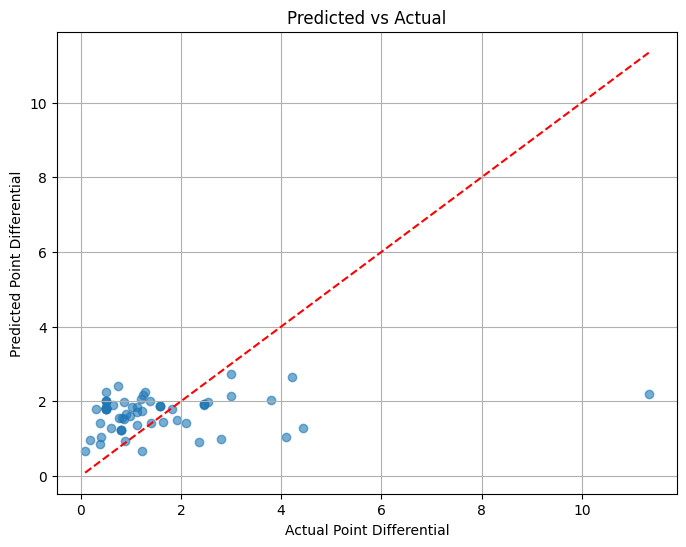

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel("Actual Point Differential")
plt.ylabel("Predicted Point Differential")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()


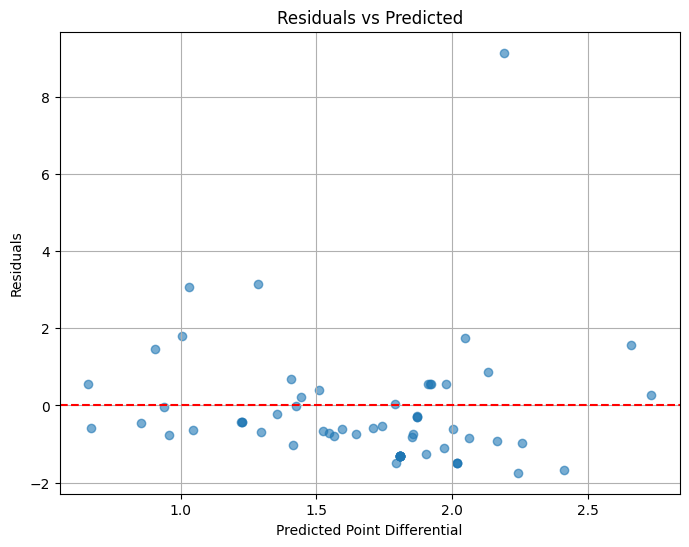

In [48]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Point Differential")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.show()


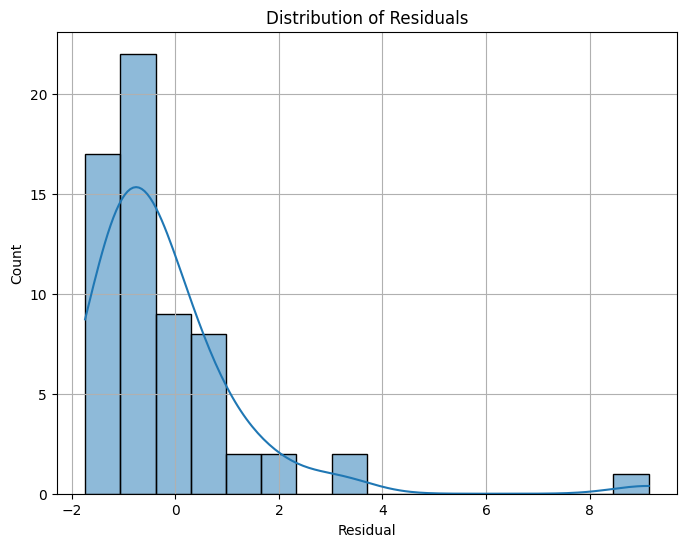

In [49]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.grid(True)
plt.show()


# Deep Learning

In [ ]:
%load_ext autoreload
%autoreload 2
from cfb import FootballNetCustom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


In [52]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [53]:
model = FootballNet(input_dim=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [54]:
def train(model, loader, optimizer, criterion, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.4f}")


In [55]:
def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            preds.append(outputs)
            targets.append(y_batch)
    y_pred = torch.cat(preds).numpy()
    y_true = torch.cat(targets).numpy()
    return y_true, y_pred


In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def print_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")

In [57]:
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Point Differential")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Residual Plot")
    plt.show()

In [58]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual Point Differential")
    plt.ylabel("Predicted Point Differential")
    plt.title("Predicted vs Actual")
    plt.show()

RMSE: 2.08
MAE : 1.29


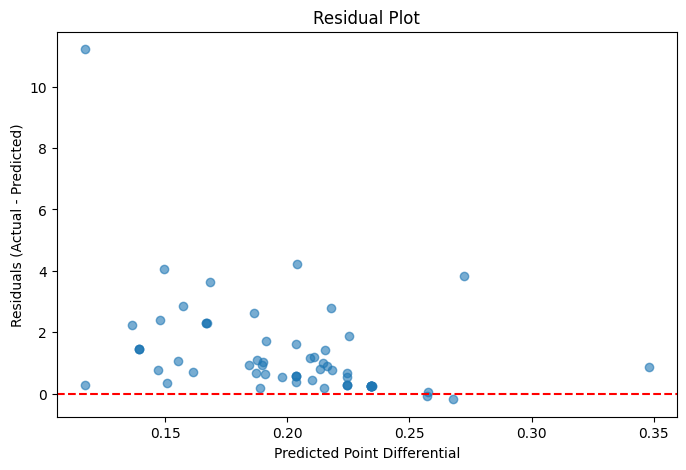

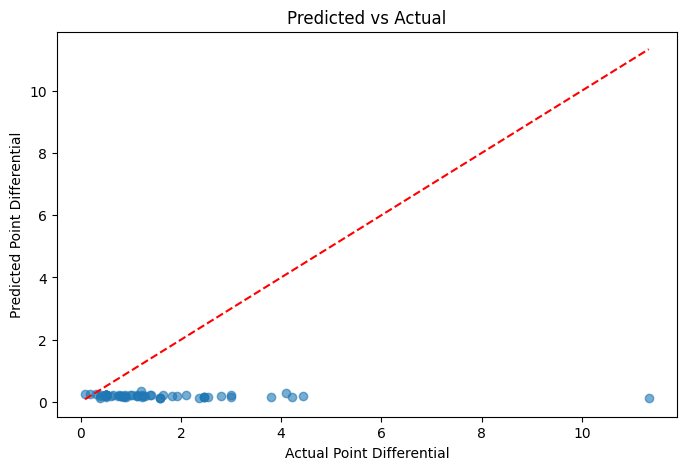

In [59]:
y_true, y_pred = evaluate(model, test_loader)
print_metrics(y_true, y_pred)
plot_residuals(y_true, y_pred)
plot_predictions(y_true, y_pred)

Linear Baseline had RMSE: 1.38 and MAE: 0.75. Deep learning had RMSE: 1.32 and MAE : 0.57. This is an improvement. 